### TODO:


- shift 'high' & 'low' by one to avoid forward bias for volume / volatility computation
- Use GridsearchCV to find the optimal number of trees for random-forest regressor.
- Should we consider log of volume and log of moving averages?

### Assumptions undertaken | done tasks:
- Plot ACF & PACF to obtain the good number of lags + complete the overleaf part.
    - Number of lags determined by the minimization of the BIC
    - ACF & PACF are plot
    - TODO: overleaf
- Re-queried data with daily intervals instead of hourly returns
    - updated the period burn to match new frequency
    - updated the rolling plots to match new frequency
    - TODO: update overleaf report accordingly
    - We re-queried on-chain data as of 21/12/19 - data should match at the daily level
    
- add intercept in design matrix
- removal of all transactions with zero 'close' & removal of first two weeks of each trading period  
    - Assumption: on-chain transactions prior to quotation are left aside.
    - Upsides: allows to remove prices equal to 0 and then remove first two weeks of trading (to avoid possible extreme outliers)
- include back on-chain transactions FROM exchanges and add a dummy variable identifying whether it comes FROM or TO an exchange
    - added a count variable for transactions from one exchange's wallet to another
    - underlying data in its current iteration (as of 21/12/19) only has transactions TO exchanges' wallets and not FROM as i.e. if someone had sent money FROM the exchange TO an unknown wallet
    - in its previous iteration, we missed transactions from one exchange to another, while they were legitimate

We will consider the GARCH(1,1) with Student-t innovations model of the log-returns process \{$y_t$, $t\in \mathcal{Z}$\}, for $t = 1, \dots, T$:

$$    y_t = \epsilon_t \cdot h_t^{1/2} $$

where $\epsilon_t$ is a sequence of $i.i.d.$ variables $\sim$ ${\mathcal{t}}(\nu)$, 

$$ h_t = \omega + \alpha \cdot y^2_{t-1} + \beta \cdot h_{t-1}$$

for $\omega > 0$; $\alpha,\beta \geq 0$; ${\mathcal{t}}(\nu)$ denotes the Students-t distribution with $\nu$ degrees of freedom. The restriction on the GARCH parameters $\omega$, $\alpha$, $\beta$ guarantee the conditional variance's positivity.

The term $(\alpha + \beta)$ is the degree of persistence in the autocorrelation of the squares which controls the intensity of the clustering in the variance process. With a value close to one, past shocks and past variances will have a longer impact on the future conditional variance.


In [15]:
import numpy as np 
import pandas as pd 
import os

In [16]:
token_data = pd.read_csv('ethereum_erc20_tokens.csv')

In [181]:
def compute_for_token(token_address,
    token_initials,
    initial_date = None
    ):
    
    import pandas as pd
    import numpy as np
    import os
    from datetime import datetime
    import matplotlib.pyplot as plt
    import scipy
    import sklearn
    import time
    import os.path
    from arch import arch_model
    from arch.univariate import ConstantMean, GARCH, StudentsT
    
    from sklearn.model_selection import train_test_split
        
    """######################## Load the dataframe of on-chain transactions #############################"""

    # Read the .csv file containing all exchanges relevant data
    exchange_data = pd.read_csv('all_exchanges.csv')
    
    df = pd.read_csv('./data/{}/raw_big_query.csv'.format(token_initials))
    display(df.shape)
    df.block_timestamp = df.block_timestamp.apply(lambda x: datetime.strptime(x[:-6],'%Y-%m-%d %H:%M:%S') )

    # transactions towards the different exchanges
    exchange_txn_count = (
        df
        .groupby('to_address')
        .count()
        .reset_index()
        .loc[:,['to_address','token_address']]
        .merge(exchange_data, right_on='Address',left_on='to_address')
        .drop(['Address','to_address', 'Txn Count', 'Balance'], axis = 1)
        .rename(columns={'token_address':'transaction_count'})
        .sort_values('transaction_count', ascending=False)
    )
    
    #display(exchange_txn_count.head(20))
    tokens.loc[tokens.initials == token_initials,'most active exchange'] = exchange_txn_count.iloc[0,1]

    # We convert the values (stored as strings) to floats
    df.value=df.value.astype(float)

    exchange_data.Address

    # We create a dummy variable to identify transactions
    # from one exchange's wallet to another   
    df['from_exchange'] = 1 
    # we subselect the dataframe where the 'from_address' is not in the list of exchange addresses 
    df.loc[~df['from_address'].isin(exchange_data.Address), 'from_exchange'] = 0
    
    trans = df
    print('We found {} transactions towards exchanges.'.format( df.shape[0]) )
    tokens.loc[tokens.initials == token_initials,'transactions to exchanges'] = df.shape[0]
        
    address_tran_counts = (
        trans
        .groupby('from_address')
        .count()
        .sort_values(by='value', ascending=False)
        .to_address
    )
    
    trans = (
        df
        .sort_values('block_timestamp')
        .reset_index()
        .drop('index', axis=1)
    )
    
    trans = trans.rename(columns={'block_timestamp': 'time'})

    # We transform the times UTC to naive times
    trans.time = trans.time.values

    min_date = datetime.timestamp(trans.time[0])
    max_date = datetime.timestamp(trans.time.iloc[-1])
    max_date, min_date
            
    """######################## Load the dataframe of off-chain transactions #############################"""  
    
    price_raw = pd.read_csv('./data/{}/raw_crypto_compare.csv'.format(token_initials))
    price = price_raw
    price = price.sort_values('time').reset_index()

    price.loc[:,'time_readable'] = (
        price
        .time
        .apply(lambda x:datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S') )
    )
    
    # We convert the price dates into datetime objects
    price.time=price.time.apply(lambda x: datetime.fromtimestamp(x))

    if initial_date:
        price = price.loc[price.time >initial_date]

    # "volumeto" means the volume in the currency that is being traded
    # "volumefrom" means the volume in the base currency that things are traded into.
    price = (
        price
        .drop(
            ['time_readable', 'conversionSymbol','conversionType', 'open', 'volumefrom','index'],
            axis=1
        )
    )
    
    # We consider the BTC volume as what we refer to as 'volume'
    price = (
        price
        .rename(columns={'volumeto':'volume'}) 
        .drop('Unnamed: 0', axis=1)
    )
    
    # filters out all zero prices
    price = price[(price[['close']] != 0).all(axis=1)]
    print('We have {} observations.'.format( price.shape[0]) )
    
    '''############################ COMPUTE ON-CHAIN AGGREGATES ##################################'''
    
    # We compute the returns of the closing prices
    price.loc[:,'returns'] = np.log(price['close']).diff()
        
    # In order to transform dates to non local time
    trans.loc[:,'time']= trans.time.values

    min_time, max_time = price.time.iloc[[0,-1]].values
    min_trans_time, max_trans_time = trans.time.iloc[[0,-1]].values

    # We only keep the transactions for which we have price data
    #trans = trans.loc[(trans['time'] >= min_time)]   
    '''
    TEST PURPOSES: 
    we only keep the transactions for which we have on-chain data
    Current maximum off_chain timestamp as of 21/12/2019 is 21/12/2019
    Current maximum on_chain time is 2019-12-21 19:29:00 (as of 21/12/2019)
    '''
    price = price.loc[(price['time'] <= max_trans_time)]   
        
    # We create bins of hourly intervals and we aggregate the on-chain transactions in the bins
    cut = pd.cut(trans.time, bins = price.time, duplicates='drop')

    '''
    GOAL: merge on-chain and off-chain datasets.
    PROCEDURE:
    Group by the number of tokens exchanged (value) and compute the sum
    and count of this feature.
    Yields: 'onchain_volume' & 'onchain_trans'
    Perform the same by grouping by 'from_exchange' dummy variable
    and taking a count of it, to obtain the number of 
    transactions coming FROM exchanges
    '''
    data = price

    for _GROUPBY in ['value','from_exchange']:
        # sum variable of FROM exchanges transactions
        trans_cut = trans.groupby(cut)[_GROUPBY].aggregate(['count','sum'])
              
        # We show 5 examples of intervals for readability
        trans_cut.sample(5)
        trans_cut = trans_cut.reset_index()
        trans_cut.time = trans_cut.time.apply(lambda x:x.right)
        trans_cut.time = pd.to_datetime(trans_cut.time)
               
        data = (
            trans_cut
            .merge(data, left_on='time', right_on='time')
        )
        
        if _GROUPBY == 'value':
            data = data.rename(columns={'sum':'onchain_volume', 'count':'onchain_trans'})
        else:
            data = (
                data
                .rename(columns={'sum':'from_exchanges_transactions'})
                .drop('count', axis=1)
            )
    
    # if we have daily intervals: burn the first two weeks i.e. 14 days
    data = data[14:]
    
    
    '''############################ GARCH PROCEDURE ##################################'''

    am = ConstantMean(data['returns'][1:])
    am.volatility = GARCH(1, 0, 1)
    am.distribution = StudentsT()

    res = am.fit(disp = 'off', update_freq = 7)
    GARCH_param = (
        pd
        .DataFrame(
            {
                'Asset' : 'Stock',
                'omega' : [res.params['omega']],
                'alpha' : [res.params['alpha[1]']],
                'beta' : [res.params['beta[1]']],
                'nu' : [res.params['nu']],
                'AIC' : [res.aic],
                'BIC' : [res.bic],
                'GARCH parameters' : [[1,1]]
            }
        )
    )
    
    GARCH_param.set_index('Asset', inplace = True)
    
    #display(GARCH_param)
    #display(res.summary())   
    #display(res)

    for p in range(1,10):
        for q in range(1,10):
            am = ConstantMean(data['returns'][1:])
            am.volatility = GARCH(p, 0, q)
            am.distribution = StudentsT()

            res = am.fit(disp = 'off', update_freq = 7)
            #display(res)
            new_GARCH_param = (
                pd
                .DataFrame(
                    {
                        'Asset' : 'Stock',
                        'omega' : [res.params['omega']],
                        'alpha' : [res.params['alpha[1]']],
                        'beta' : [res.params['beta[1]']],
                        'nu' : [res.params['nu']],
                        'AIC' : [res.aic],
                        'BIC' : [res.bic],
                        'GARCH parameters' : [[p,q]]
                    }
                )
            )
            GARCH_param = GARCH_param.append(new_GARCH_param, ignore_index = True, sort=False)

    GARCH_param['_TICKER'] = token_initials
    display(GARCH_param.sort_values(by='BIC').head(10))
    
    
    '''############################ DATA CLEANING ##################################'''
    # We remove the rows where one value is missing
    data = (
        data
        .replace([np.inf, -np.inf], np.nan) # remove rows with infinite values
        .dropna()
        .reset_index()
        .drop('index', axis=1)
    )
    
    lower_bound = -100
    upper_bound = 100
    data = data.loc[(data['returns'] >= lower_bound) & (data['returns'] <= upper_bound)]
    data.sort_values('time')   


    '''############################ PLOTS ##################################'''

    # The style of the figure can be set globally using the matplotlib rc parameters.
    plt.rcParams['axes.grid'] = True
    plt.rcParams["figure.figsize"] = [10,6]
    
    from statsmodels.graphics.tsaplots import plot_pacf
    from statsmodels.graphics.tsaplots import plot_acf

    plot_pacf(data.returns, lags=list(range(1,48)))
    plt.title('Partial Autocorrelation of {} (starting at 1 lag)'.format(token_initials))
    plt.show()
    plot_acf(data.returns, lags=list(range(1,48)))
    plt.title('Autocorrelation of {} (starting at 1 lag)'.format(token_initials))
    plt.show()
    

    nb_figures = 6
    
    fig, (ax1,ax11, ax5, ax2, ax3, ax4, ) = plt.subplots(nb_figures, 1, figsize=(15,10), sharex =True)
    for ax in fig.axes:
        plt.sca(ax)
        plt.xticks(rotation=90)
    plt.suptitle('{} data'.format(token_initials))
    plt.subplots_adjust(hspace = 0.25) # the amount of height reserved for space between subplots
    ax1.set_title('Price evolution in BTC')
    ax1.plot(data.time, data.close)
    
    ax11.set_title('Daily return of token price')
    ax11.plot(data.time, data.returns)
    ax11.set_ylim((-0.3,0.3))
    
    ax5.set_title('Volume evolution in BTC')
    ax5.plot(data.time, data.volume)

    # Plots if data consist of daily intervals        
    ax2.set_title('Rolling 7-day exchange volume evolution in BTC')
    ax2.plot(data.time,data.volume.rolling(7).mean())
    
    ax3.set_title('Rolling 7-day on-chain transaction count to exchanges')
    ax3.plot(data.time,data.onchain_trans.rolling(7).mean())
    
    ax4.set_title('Rolling 7-day on-chain volume evolution in BTC')
    ax4.plot(data.time,data.onchain_volume.rolling(7).mean())
    
    # Rotates and right aligns the x labels, and moves the bottom of the
    # Axes up to make room for them
    fig.autofmt_xdate()
    
    plt.savefig('./data/{}/all_plots.png'.format(token_initials))

    data['intercept'] = 1
    
    #display(data)
    
    '''############################ DESIGN MATRICES ##################################'''
    
    y_returns = data.returns.values
    y_volume = data.volume.values
    
    X_returns = (
        data
        .loc[
            :,
             [
              'intercept', 'onchain_trans', 'onchain_volume',
              'high', 'low', 'volume', 'from_exchanges_transactions'
             ]
            ]
        .values
    )
    
    X_volume = (
        data
        .loc[
            :,
            [
                'intercept', 'onchain_trans', 'onchain_volume',
                'high', 'low', 'from_exchanges_transactions'
            ]
        ]
        .values
    )
    
    '''
    The following lines creates an iterator to iterate by pair of y_ | x_
    We would like to run for pairs of y_returns, X_returns, likewise for volume
    '''
    lis = (y_returns, X_returns, y_volume, X_volume)
    it = iter(lis)
    
    for y in it:
        
        X = next(it)
        
        from sklearn.impute import SimpleImputer

        results = {}
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=2, shuffle=False)
        X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(X_train,y_train,test_size=0.33, random_state=2)
        
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        scaler.fit(X_train_train)

        X_train_train = scaler.transform(X_train_train)
        X_train_test = scaler.transform(X_train_test)
        X_test = scaler.transform(X_test)
        
        '''############################ Linear Regression ##################################'''
        from sklearn.linear_model import LinearRegression

        reg = LinearRegression().fit(X_train_train, y_train_train)
              
        # If the the series is Returns, set column_name to 'returns'
        # Else set the column name to 'off-chain volume'
        col_name = 'returns' if np.array_equiv(X, X_returns) else 'off-chain volume' 
        # col_name = 'returns' if (X == X_returns).all() else 'off-chain volume' 
        
        results['linear regression score of ' + col_name] = reg.score(X_test, y_test)
        print('linear regression score of ' + col_name, reg.score(X_test, y_test))

        reg_score = reg.score(X_test, y_test)
        tokens.loc[tokens.initials == token_initials,'linear regression score of '+col_name] = reg_score

        # Start the scatter plots here
        nb_rows = 2
        nb_columns = 1
        
        fig, (ax_linreg, ax_tree) = plt.subplots(nb_rows, nb_columns, figsize=(15,10), sharex =True)
        for ax in fig.axes:
            plt.sca(ax)
            plt.xticks(rotation=90)
        plt.suptitle('{} linear regression and RF Regressor for '.format(token_initials) + col_name)
        ax_linreg.scatter(y_test, reg.predict(X_test))
        ax_linreg.plot(y_test,y_test, 'k')
        ax_linreg.set_title(
            'Linear regression of ' + col_name +
            ' prediction vs. true validation data token {}\n score: {:.3f} '
            .format(token_initials, reg_score)
        )
        # Rotates and right aligns the x labels, and 
        # Moves the bottom of the axes up 
        # To make room for them
        fig.autofmt_xdate()
        
        '''############################ RF Regressor ##################################'''
        from sklearn.ensemble import RandomForestRegressor
        
        clf = RandomForestRegressor(n_estimators = 100)
        clf = clf.fit(X_train_train, y_train_train)
        results['RF Regressor score of ' + col_name] = clf.score(X_test,y_test)
        print('RF Regressor score of ' + col_name, clf.score(X_test,y_test) )
        clf_score = clf.score(X_test,y_test) 

        tokens.loc[tokens.initials == token_initials,'RF Regressor score of ' + col_name] = clf_score

        ax_tree.scatter(y_test, clf.predict(X_test))
        ax_tree.plot(y_test,y_test, 'k')
        ax_tree.set_title(
            'RF Regressor prediction of ' + col_name +
            ' vs. true validation data token {}\n score:{:.3f} '
            .format(token_initials, clf_score)
        )
        # Rotates and right aligns the x labels, and 
        # Moves the bottom of the axes up 
        # To make room for them
        fig.autofmt_xdate()
    
        plt.savefig('./data/{}/regression_plots.png'.format(token_initials))
        plt.savefig('./data/{}/'.format(token_initials) + col_name + '_regression_plots.png')


### Run the program

In [182]:
tokens = os.listdir('data')

In [183]:
# We keep the tokens for which we have both on-chain and off-chain data
tokens = pd.Series(tokens)
keep = (
    tokens
    .apply(lambda x: 
           os.path.exists('data/{}/raw_big_query.csv'.format(x)) 
           and 
           os.path.exists('data/{}/raw_crypto_compare.csv'.format(x))
    )
)
remove_tokens = tokens.loc[~keep]
tokens = tokens.loc[keep]
tokens = token_data.merge(tokens.to_frame(), left_on='initials', right_on=0).drop(0, axis=1) #token_data contains all info
tokens.loc[:,'linear model score'] = 0
tokens.loc[:,'transactions to exchanges'] = 0
tokens = tokens.drop(['holders','daily_volume','price'], axis = 1)
#tokens.dtypes

### Test procedure

In [1]:
# from https://stackoverflow.com/questions/9031783/hide-all-warnings-in-ipython
# get a toggle button to remove error boxes once computation is done
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

(65174, 9)

We found 65174 transactions towards exchanges.
We have 781 observations.


C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code 

,omega,alpha,beta,nu,AIC,BIC,GARCH parameters,Asset,_TICKER
2,0.000699,0.233528,2.343432e-01,3.297363,-2166.744035,-2138.904780,"[1, 2]",Stock,ENJ
11,0.000699,0.233527,2.342850e-01,3.297411,-2164.744035,-2132.264904,"[2, 2]",Stock,ENJ
12,0.000817,0.290020,3.760808e-14,3.336562,-2167.445810,-2130.326803,"[2, 3]",Stock,ENJ
4,0.000782,0.291633,4.985378e-02,3.337822,-2167.312872,-2130.193865,"[1, 4]",Stock,ENJ
13,0.000816,0.289720,4.643130e-16,3.338811,-2165.445783,-2123.686901,"[2, 4]",Stock,ENJ
23,0.000635,0.214662,2.796078e-02,3.604718,-2171.779839,-2120.741205,"[3, 5]",Stock,ENJ
28,0.000511,0.148213,7.670398e-01,3.248720,-2157.259033,-2120.140026,"[4, 1]",Stock,ENJ
30,0.000817,0.289997,0.000000e+00,3.336649,-2163.445810,-2117.047052,"[4, 3]",Stock,ENJ
22,0.000817,0.289995,3.409168e-11,3.336705,-2163.445810,-2117.047052,"[3, 4]",Stock,ENJ
32,0.000635,0.214593,2.794548e-02,3.604834,-2169.779839,-2114.101329,"[4, 5]",Stock,ENJ


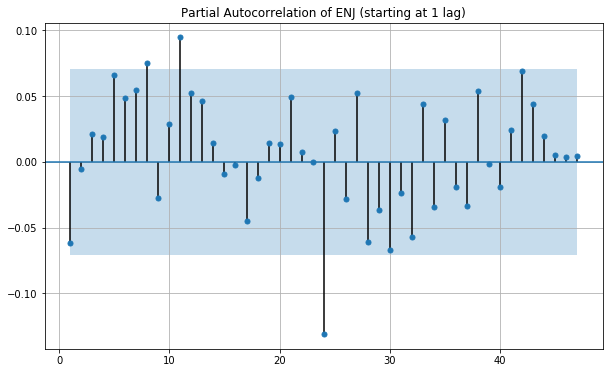

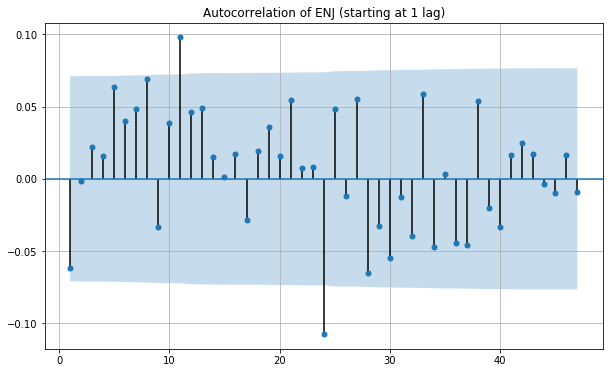

linear regression score of returns -0.5676404513157818
RF Regressor score of returns 0.052693973899483604
linear regression score of off-chain volume -7.067294100291811
RF Regressor score of off-chain volume -8.545326842718204


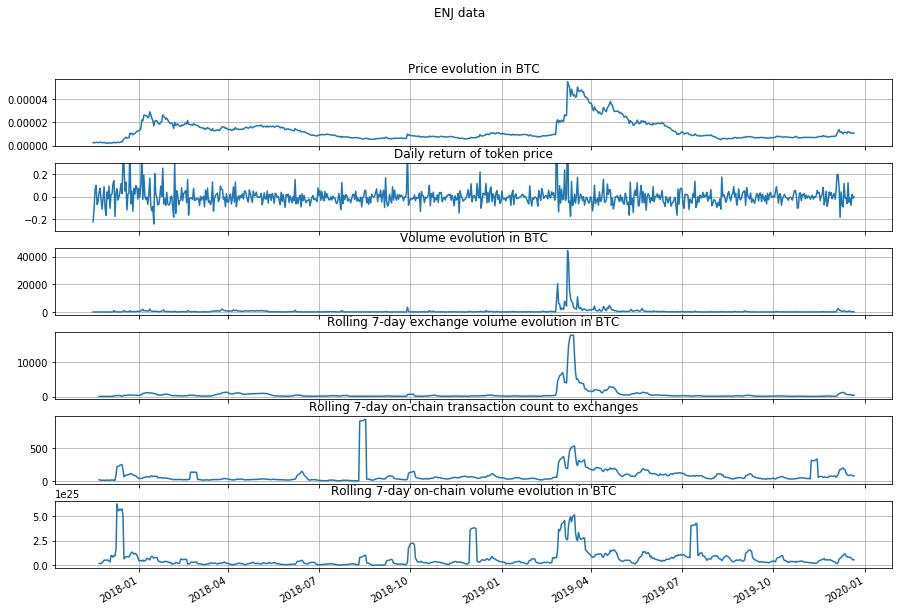

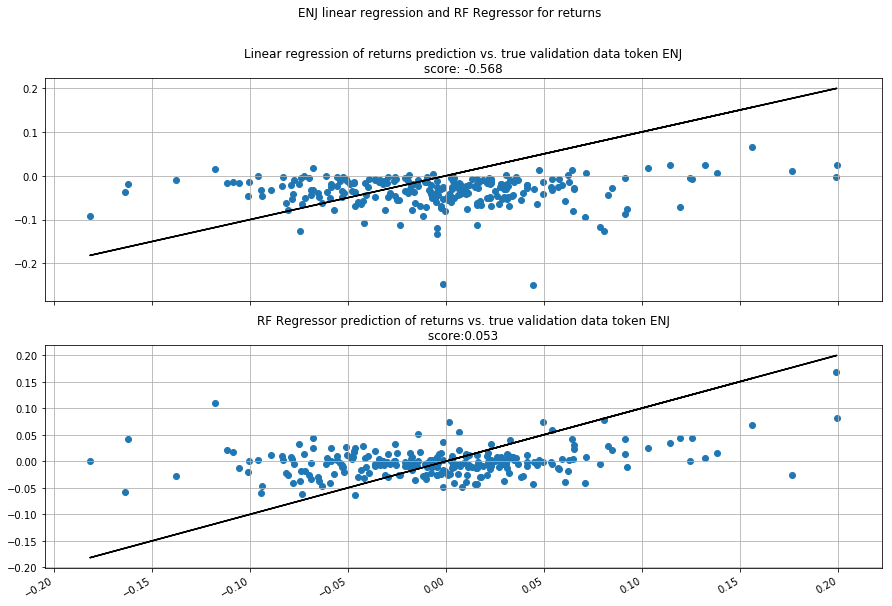

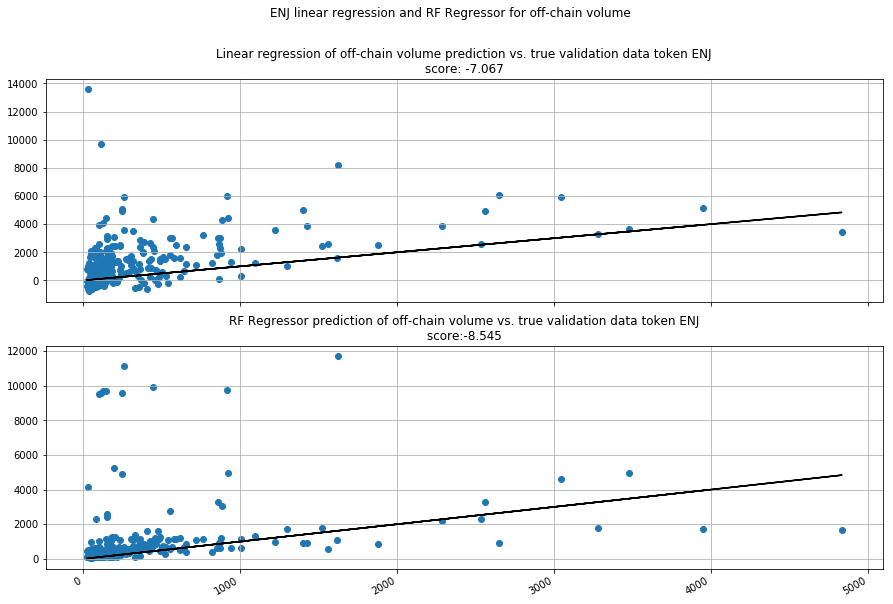

In [185]:
import warnings
warnings.filterwarnings('ignore')
# hardcode our test procedure
compute_for_token('0xf629cbd94d3791c9250152bd8dfbdf380e2a3b9c', 'ENJ')

(29863, 9)

We found 29863 transactions towards exchanges.
We have 691 observations.


,omega,alpha,beta,nu,AIC,BIC,GARCH parameters,Asset,_TICKER
0,0.001378,0.425937,4.601795e-01,2.892476,-1825.157521,-1803.000866,"[1, 1]",NaN,THETA
1,0.001378,0.425937,4.601795e-01,2.892476,-1825.157521,-1803.000866,"[1, 1]",Stock,THETA
10,0.001390,0.425509,4.561984e-01,2.891445,-1823.157936,-1796.569950,"[2, 1]",Stock,THETA
2,0.001378,0.425900,4.601586e-01,2.892440,-1823.157521,-1796.569534,"[1, 2]",Stock,THETA
11,0.002008,0.426910,1.271811e-16,2.890749,-1821.162920,-1790.143602,"[2, 2]",Stock,THETA
3,0.001370,0.425232,4.577301e-01,2.894482,-1821.159531,-1790.140214,"[1, 3]",Stock,THETA
19,0.001390,0.425475,4.563339e-01,2.891170,-1821.157936,-1790.138618,"[3, 1]",Stock,THETA
4,0.001287,0.425539,4.262291e-01,2.921338,-1819.555924,-1784.105276,"[1, 4]",Stock,THETA
20,0.002269,0.441937,9.211260e-02,2.877590,-1819.256085,-1783.805436,"[3, 2]",Stock,THETA
28,0.002370,0.446597,1.060072e-01,2.876699,-1819.222595,-1783.771946,"[4, 1]",Stock,THETA


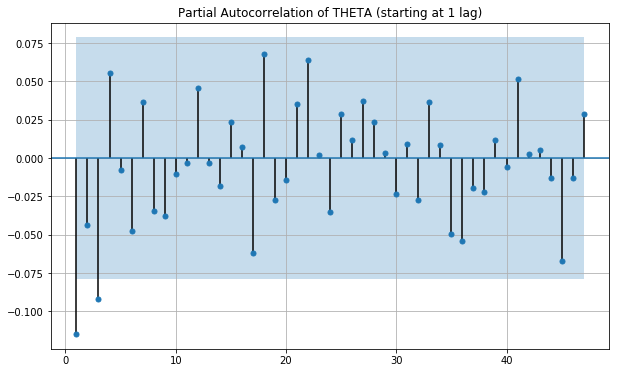

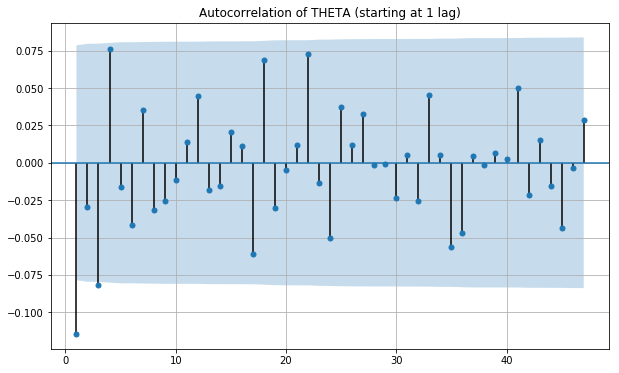

linear regression score of returns -0.08858657862665087
RF Regressor score of returns -0.018882009283145873
linear regression score of off-chain volume -0.09415410196130214
RF Regressor score of off-chain volume 0.2732453714395846


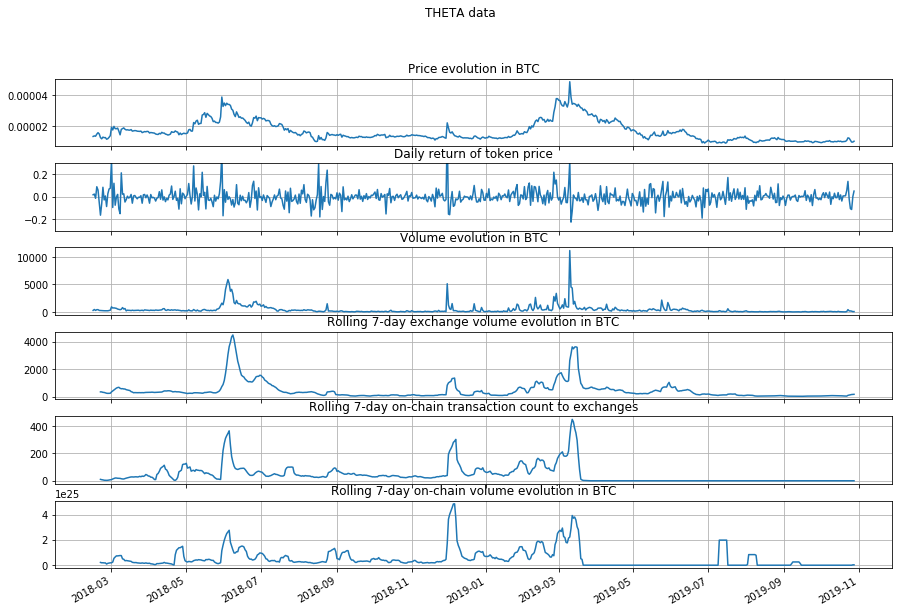

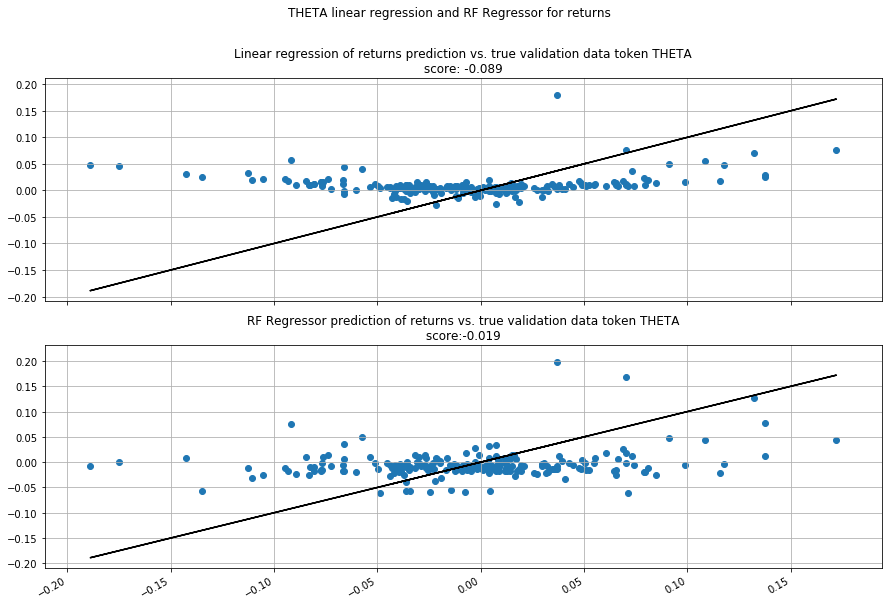

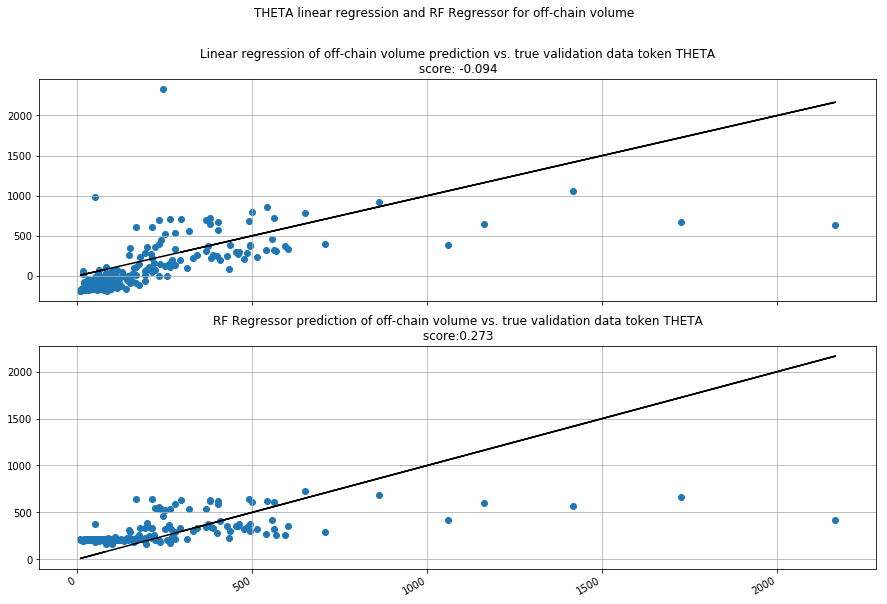

In [186]:
# hardcode our test procedure
compute_for_token('0x3883f5e181fccaf8410fa61e12b59bad963fb645', 'THETA')

(176283, 9)

We found 176283 transactions towards exchanges.
We have 863 observations.


C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code 

C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code 

,omega,alpha,beta,nu,AIC,BIC,GARCH parameters,Asset,_TICKER
0,0.000058,0.115103,8.781775e-01,4.497665,-2638.643650,-2614.935146,"[1, 1]",NaN,ZRX
1,0.000058,0.115103,8.781775e-01,4.497665,-2638.643650,-2614.935146,"[1, 1]",Stock,ZRX
13,0.000057,0.142442,3.418237e-01,5.220920,-2636.426165,-2593.750859,"[2, 4]",Stock,ZRX
14,0.000057,0.170241,2.721441e-07,4.776405,-2637.472680,-2590.055674,"[2, 5]",Stock,ZRX
37,0.000133,0.129730,7.769567e-01,4.346138,-2632.064078,-2589.388771,"[5, 1]",Stock,ZRX
6,0.000057,0.203784,3.040466e-01,4.687073,-2635.465995,-2588.048988,"[1, 6]",Stock,ZRX
10,0.000032,0.086490,8.973073e-01,13.481284,-2613.942403,-2585.492199,"[2, 1]",Stock,ZRX
30,0.000065,0.159907,5.184417e-01,4.596797,-2631.768838,-2584.351831,"[4, 3]",Stock,ZRX
23,0.000057,0.170267,3.355916e-08,4.776189,-2635.472681,-2583.313974,"[3, 5]",Stock,ZRX
7,0.000057,0.203766,3.040743e-01,4.687012,-2633.465995,-2581.307288,"[1, 7]",Stock,ZRX


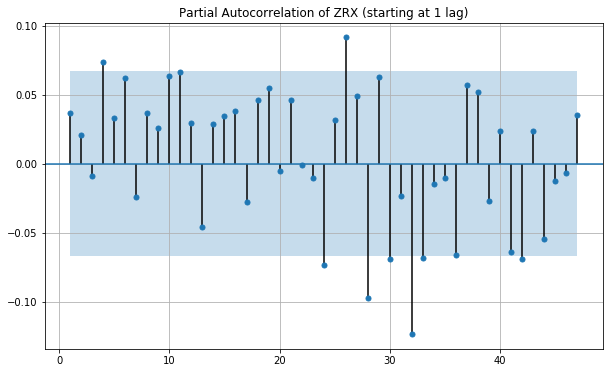

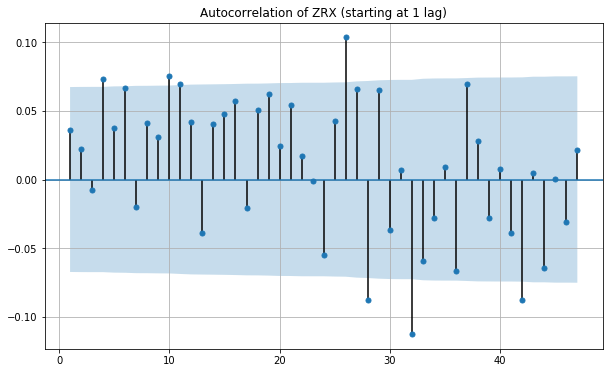

linear regression score of returns -0.02471576443475687
RF Regressor score of returns -0.8922745526835969
linear regression score of off-chain volume -2.513522298584115
RF Regressor score of off-chain volume 0.5654706271711527


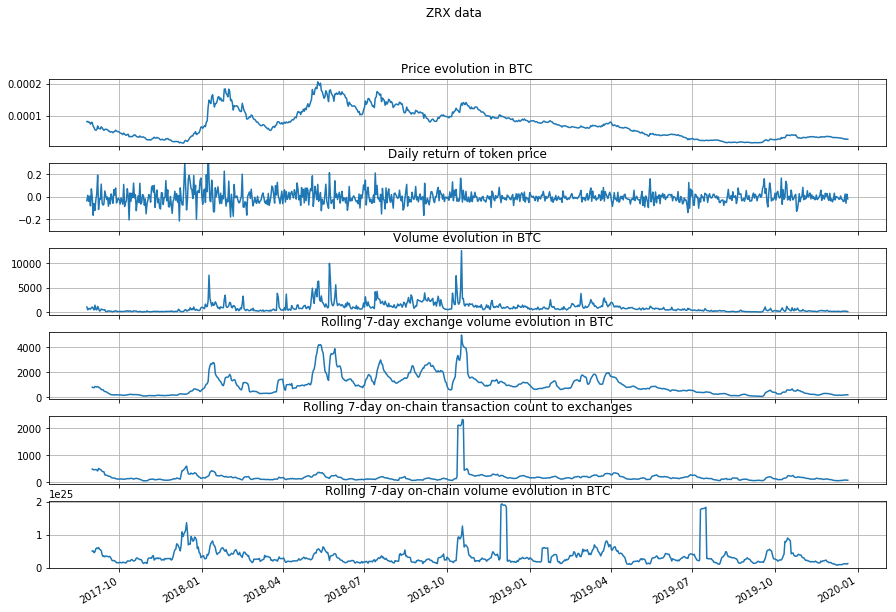

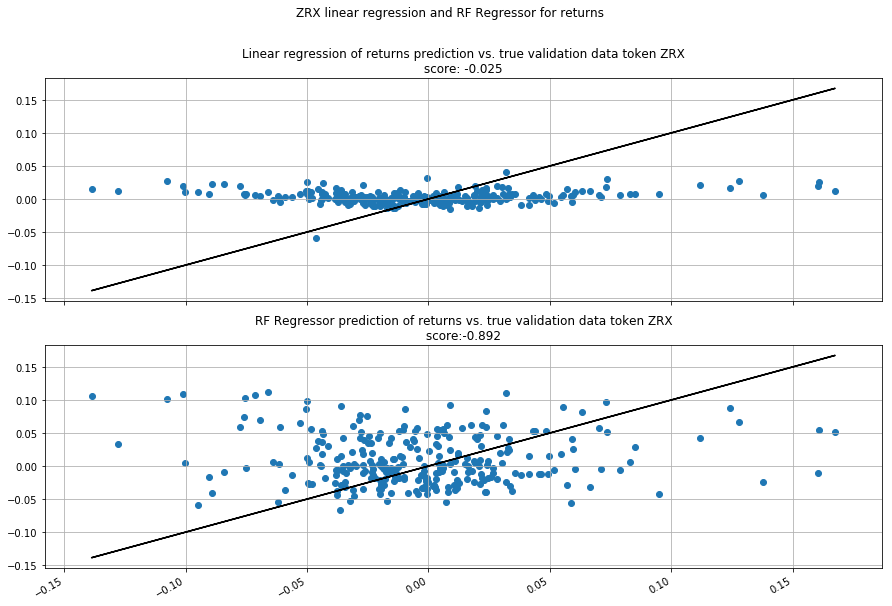

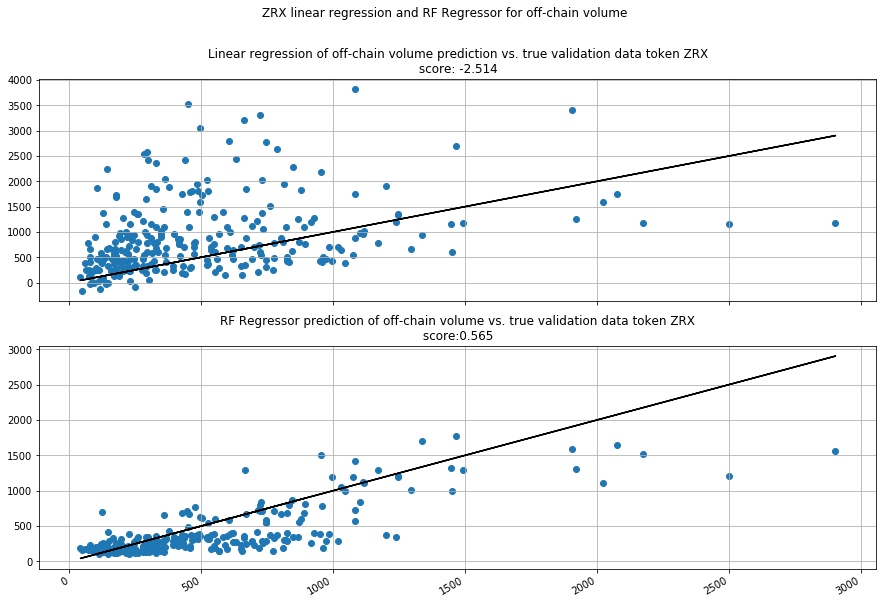

In [187]:
# hardcode our test procedure
compute_for_token('0xe41d2489571d322189246dafa5ebde1f4699f498', 'ZRX')

### Run the program for all tokens

### Printing results in LaTeX

### Print ML techniques scores